In [5]:
import json
import sys

sys.path.append("/root/circuit-finder")
from circuit_finder.patching.eap_graph import EAPGraph
from circuit_finder.constants import ProjectDir
from circuit_finder.plotting import show_attrib_graph

results_dir = ProjectDir / "results" / "ioi_ABBA_template_0_prompts" / "batch_0"
assert results_dir.exists()

# Print Hparams

In [6]:
config = json.load(open(results_dir / "config.json"))
for key, value in config.items():
    print(f"{key}: {value}")

dataset_path: datasets/ioi/ioi_ABBA_template_0_prompts.json
save_dir: /workspace/circuit-finder/results/ioi_ABBA_template_0_prompts
seed: 1
batch_size: 4
total_dataset_size: 32
ablate_errors: False
first_ablate_layer: 2
verbose: False


# Show Dataset

In [7]:
import pandas as pd
pd.set_option('display.max_colwidth', None)

dataset = results_dir / "dataset.json"
with open(dataset, 'r') as f:
    dataset = json.load(f)

df = pd.DataFrame(dataset)
df.head()

,clean,answer,wrong_answer,corrupt
0,"<|endoftext|>Then, Peter and Mark went to the school. Mark gave a kiss to",Peter,Mark,"<|endoftext|>Then, Ian and Brian went to the school. Steven gave a kiss to"
1,"<|endoftext|>Then, River and Carter went to the school. Carter gave a necklace to",River,Carter,"<|endoftext|>Then, Jonathan and Jake went to the school. Aaron gave a necklace to"
2,"<|endoftext|>Then, Michelle and Amy went to the house. Amy gave a ring to",Michelle,Amy,"<|endoftext|>Then, Max and Georgia went to the house. Jonathan gave a ring to"
3,"<|endoftext|>Then, Frank and Jason went to the hospital. Jason gave a ring to",Frank,Jason,"<|endoftext|>Then, Andy and Simon went to the hospital. Rose gave a ring to"


# Plot Graph

Threshold: 0.001, n_edges: 154
Threshold: 0.003, n_edges: 49
Threshold: 0.006, n_edges: 30


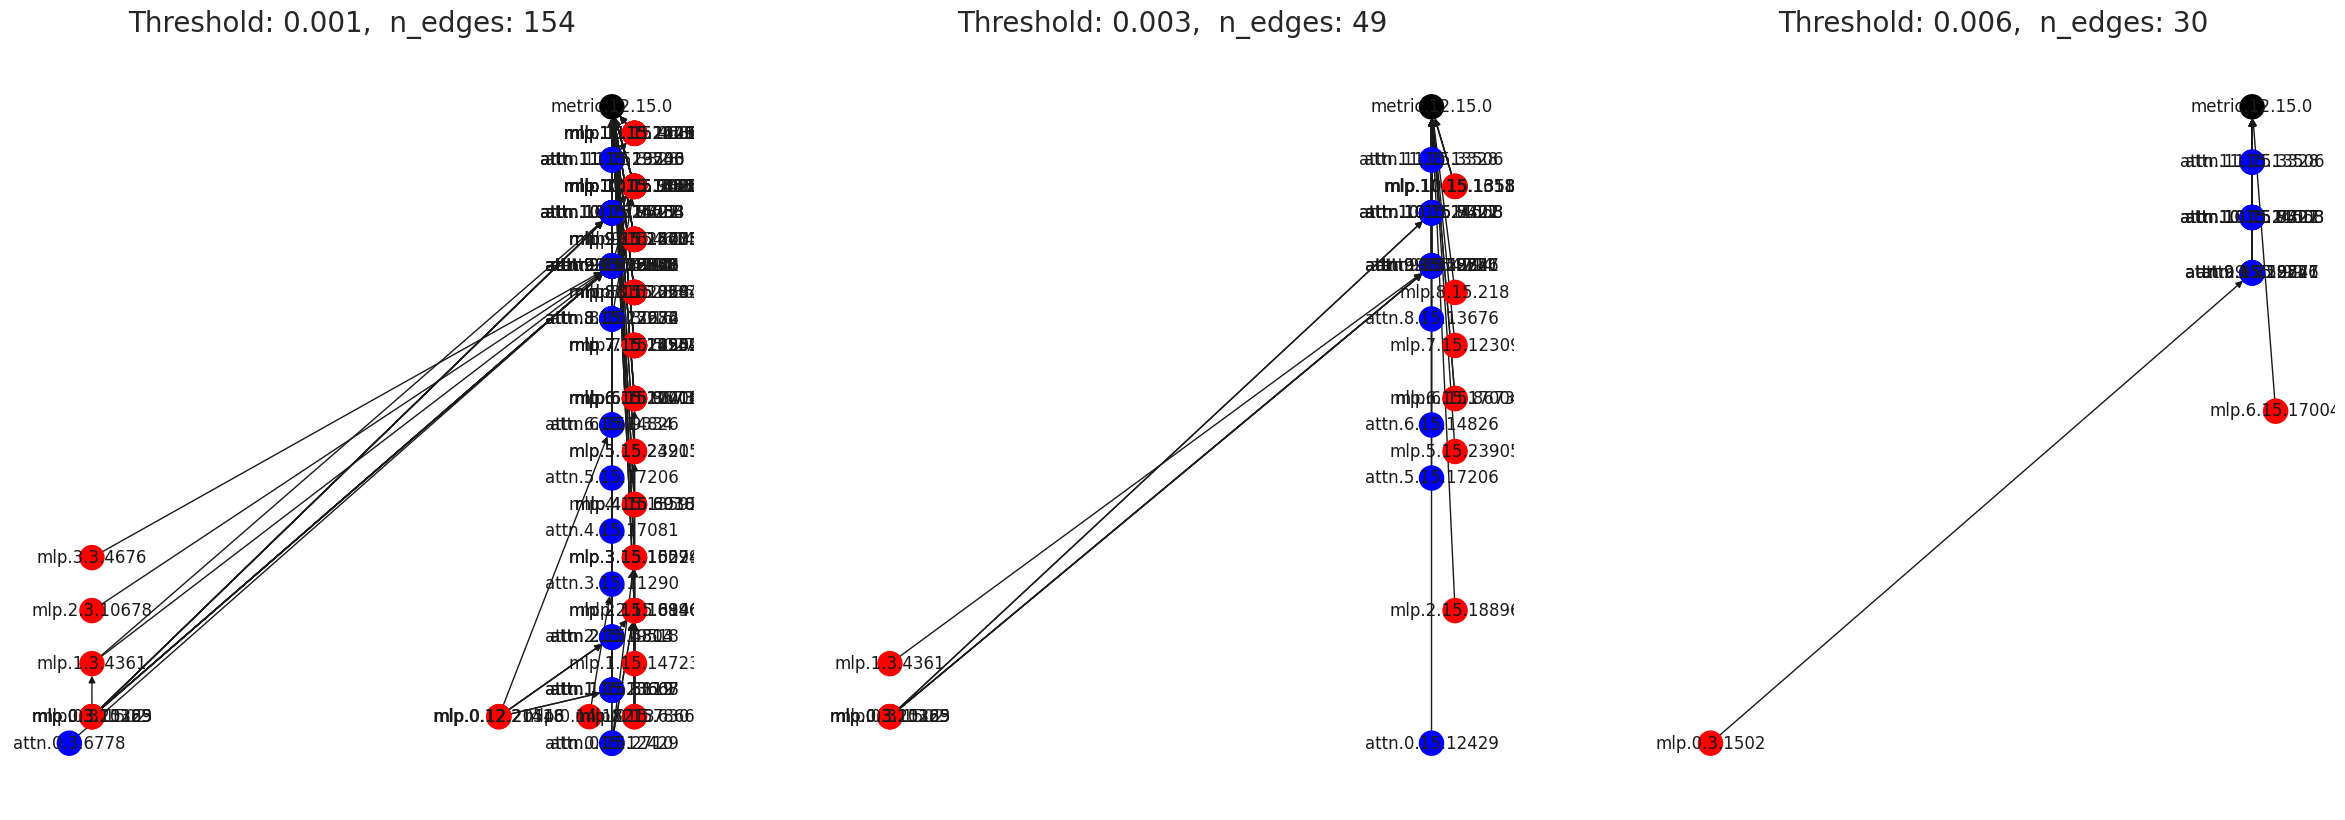

In [13]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(30, 10))
thresholds = [
    0.001,
    0.003,
    0.006,
    # 0.06,
]

for ax, threshold in zip(axs, thresholds):
    with open(results_dir / f"leap-graph_threshold={threshold}.json") as f:
        graph = EAPGraph.from_json(json.load(f))

    n_edges = len(graph.get_edges())
    print(f"Threshold: {threshold}, n_edges: {n_edges}")
    ax.set_title(f"Threshold: {threshold},  n_edges: {n_edges}", fontsize=20)

    if n_edges > 1000:
        continue
    show_attrib_graph(graph, ax=ax)


fig.show()

## Inspect the graph

In [42]:
threshold = 0.001
with open(results_dir / f"leap-graph_threshold={threshold}.json") as f:
    graph = EAPGraph.from_json(json.load(f))


In [43]:
## Print the distribution of nodes
import pandas as pd
from circuit_finder.core.types import parse_node_name

rows = []
for edge, edge_info in graph.graph:
    dest, src = edge
    if 'metric' in src: continue
    nn_grad, nn_attrib, em_grad, em_attrib = edge_info 
    src_module_type, src_layer, src_token, src_feature = parse_node_name(src)
    dest_module_type, dest_layer, dest_token, dest_feature = parse_node_name(dest)
    rows.append({
        "src_module_type": src_module_type,
        "dest_module_type": dest_module_type,
        "src_layer": src_layer,
        "dest_layer": dest_layer,
        "src_token": src_token,
        "dest_token": dest_token,
        "src_feature": src_feature,
        "dest_feature": dest_feature,
        "nn_grad": nn_grad,
        "nn_attrib": nn_attrib,
        "em_grad": em_grad,
        "em_attrib": em_attrib,
    })
df = pd.DataFrame(rows)
print(len(df))
df.head()

138


,src_module_type,dest_module_type,src_layer,dest_layer,src_token,dest_token,src_feature,dest_feature,nn_grad,nn_attrib,em_grad,em_attrib
0,mlp,metric,2,12,15,15,614,0,0.002247,0.001852,0.002247,0.001852
1,mlp,metric,2,12,15,15,10946,0,0.002176,0.002383,0.002176,0.002383
2,mlp,metric,2,12,15,15,18896,0,0.001453,0.003604,0.001453,0.003604
3,mlp,metric,3,12,15,15,10094,0,0.001037,0.002617,0.001037,0.002617
4,mlp,metric,3,12,15,15,15224,0,0.001538,0.002376,0.001538,0.002376


Index(['src_layer', 'src_module_type', 'dest_module_type', 'dest_layer',
       'src_token', 'dest_token', 'src_feature', 'dest_feature', 'nn_grad',
       'nn_attrib', 'em_grad', 'em_attrib'],
      dtype='object')


Text(0.5, 1.0, 'Total edge attribution by src layer')

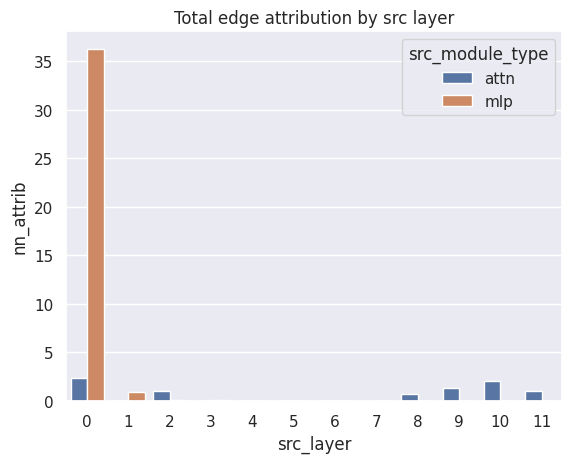

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

total_attrib_df = df.groupby(["src_layer", "src_module_type"]).sum().reset_index()
print(total_attrib_df.columns)
# Plot the total edge attribution by src layer
sns.barplot(x="src_layer", y="nn_attrib", data=total_attrib_df, hue="src_module_type")
plt.title("Total edge attribution by src layer")

Text(0.5, 1.0, 'Number of nodes in each layer')

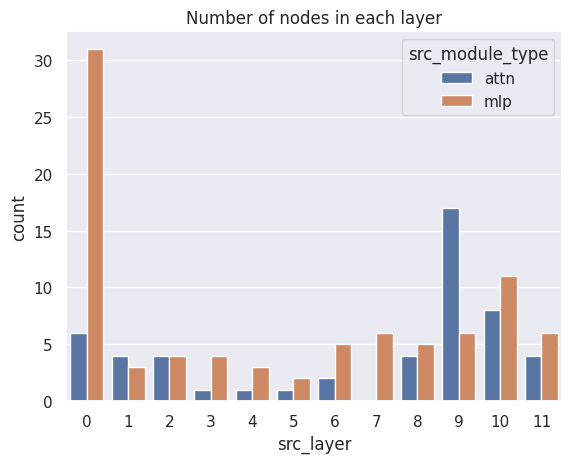

In [50]:
# Plot the number of nodes in each layer
sns.countplot(x="src_layer", data=df, hue="src_module_type")
plt.title("Number of nodes in each layer")

In [34]:
## Highest nodes by NN attrib

df.sort_values(by='em_attrib', ascending=False).head(10)

,src_module_type,dest_module_type,src_layer,dest_layer,src_token,dest_token,src_feature,dest_feature,nn_grad,nn_attrib,em_grad,em_attrib
3,attn,metric,9,12,15,15,18556,0,0.011598,0.111641,0.011598,0.111641
6,attn,metric,10,12,15,15,7422,0,0.010668,0.071950,0.010668,0.071950
8,attn,metric,10,12,15,15,9327,0,0.005133,0.055908,0.005133,0.055908
1,attn,metric,9,12,15,15,99,0,0.003153,0.053180,0.003153,0.053180
2,attn,metric,9,12,15,15,977,0,0.003848,0.047275,0.003848,0.047275
5,attn,metric,9,12,15,15,22841,0,0.003809,0.039059,0.003809,0.039059
7,attn,metric,10,12,15,15,8701,0,0.002091,0.025041,0.002091,0.025041
9,attn,metric,10,12,15,15,11553,0,0.005250,0.018722,0.005250,0.018722
10,attn,metric,10,12,15,15,24008,0,0.002025,0.014311,0.002025,0.014311
11,attn,metric,11,12,15,15,3328,0,0.003060,0.012633,0.003060,0.012633


### Layer 9 Attention SAE Features

In [38]:
from circuit_finder.neuronpedia import get_neuronpedia_url_for_quick_list

layer = 9

features = df[
    (df.src_layer == layer) & 
    (df.src_module_type == 'attn')
]['src_feature'].unique()

get_neuronpedia_url_for_quick_list(layer, features, "att-kk")

'https://neuronpedia.org/quick-list/?name=temporary_list&features=%5B%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-att-kk%22%2C%20%22index%22%3A%20%2299%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-att-kk%22%2C%20%22index%22%3A%20%22977%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-att-kk%22%2C%20%22index%22%3A%20%2218556%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-att-kk%22%2C%20%22index%22%3A%20%2219227%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-att-kk%22%2C%20%22index%22%3A%20%2222841%22%7D%5D'

In [52]:
layer = 10

features = df[(df.src_layer == layer) & (df.src_module_type == "attn")][
    "src_feature"
].unique()

get_neuronpedia_url_for_quick_list(layer, features, "att-kk")

'https://neuronpedia.org/quick-list/?name=temporary_list&features=%5B%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%2210-att-kk%22%2C%20%22index%22%3A%20%227422%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%2210-att-kk%22%2C%20%22index%22%3A%20%228701%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%2210-att-kk%22%2C%20%22index%22%3A%20%229327%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%2210-att-kk%22%2C%20%22index%22%3A%20%2211553%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%2210-att-kk%22%2C%20%22index%22%3A%20%2215734%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%2210-att-kk%22%2C%20%22index%22%3A%20%2224008%22%7D%5D'

In [53]:
layer = 0

features = df[(df.src_layer == layer) & (df.src_module_type == "mlp")][
    "src_feature"
].unique()

get_neuronpedia_url_for_quick_list(layer, features, "tres-dc")

'https://neuronpedia.org/quick-list/?name=temporary_list&features=%5B%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%220-tres-dc%22%2C%20%22index%22%3A%20%221502%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%220-tres-dc%22%2C%20%22index%22%3A%20%2211223%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%220-tres-dc%22%2C%20%22index%22%3A%20%2220165%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%220-tres-dc%22%2C%20%22index%22%3A%20%2215389%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%220-tres-dc%22%2C%20%22index%22%3A%20%22630%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%220-tres-dc%22%2C%20%22index%22%3A%20%2220546%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%220-tres-dc%22%2C%20%22index%22%3A%20%227866%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%220-tres-dc%22%2C%20%22index%22%3A%20%22

# Plot Faithfulness Curve

<Axes: xlabel='num_nodes', ylabel='faithfulness'>

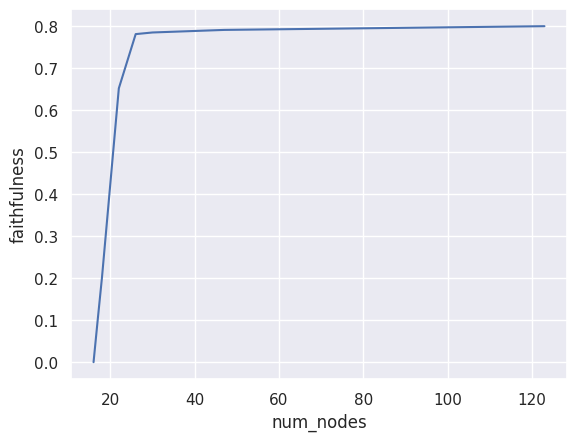

In [25]:
import seaborn as sns
sns.set_theme()

faithfulness_df = pd.read_csv(results_dir / "leap_experiment_results.csv")
sns.lineplot(data=faithfulness_df, x="num_nodes", y="faithfulness")